In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
import pickle
sns.set()

In [2]:
# Read the data
train = pd.read_csv(r"C:\Users\wale obembe\Downloads\Compressed\245550_518431_bundle_archive\train-data.csv")
# Print the first 5 rows of the dataframe
train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [3]:
# Drop the column 'Unnamed: 0'
data = train.drop('Unnamed: 0', axis=1)
# Select only the brand of the car and not the model
data['Name'] = data['Name'].apply(lambda x: x.split(' ')[0].upper())
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,MARUTI,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,HYUNDAI,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,HONDA,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,MARUTI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,AUDI,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [4]:
# Change the Year column to the years of usage
data['Year'] = dt.date.today().year - data['Year']

In [5]:
# Select the first word of the Mileage column
data['Mileage'] =data['Mileage'].apply(lambda x: str(x).split(' ')[0])
# Change 'nan' string to real missing values
data['Mileage'] = [x if x != 'nan' else np.nan for x in data['Mileage']]
# Convert the datatype to floating numbers
data['Mileage'] = pd.to_numeric(data['Mileage'])


# Select the first word of the Power column
data['Power'] =data['Power'].apply(lambda x: str(x).split(' ')[0])
# Change 'null' string to real missing values
data['Power'] = [np.nan if x=='null' else x for x in data['Power']]
data['Power'] = [np.nan if x=='nan' else x for x in data['Power']]
# Convert the datatype to floating numbers
data['Power'] = pd.to_numeric(data['Power'])


print(data['Mileage'].dtype, data['Power'].dtype)

float64 float64


In [6]:
# Check for null values
data.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
dtype: int64

In [7]:
# Replace missing values with median value of the column
mileage_median = data['Mileage'].median()
data['Mileage'] = data['Mileage'].fillna(mileage_median)

power_median = data['Power'].median() 
data['Power'] = data['Power'].fillna(power_median)

seat_median = data['Seats'].median()
data['Seats'] = data['Seats'].fillna(seat_median)

# Drop the remaining rows with missing value
data.dropna(axis=0, inplace=True)
# Check for missing values
data.isnull().sum().any()

False

In [8]:
# Classify the non-numerical features
cat_features = [x for x in data.columns if data[x].dtype == 'O']

# Classify the numerical features
num_features = [x for x in data.columns if data[x].dtype != 'O']

# Classify the discrete features
discrete_features = [x for x in num_features
                     if len(data[x].unique()) < 25]

# Classify the continuous features
continuous_features = [x for x in num_features
                      if x not in discrete_features]
# Check them out
print(f"Categorical features: {cat_features}\nNumerical features: {num_features}\
\nDiscrete features: {discrete_features}\nContinuous features: {continuous_features}")

Categorical features: ['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Engine']
Numerical features: ['Year', 'Kilometers_Driven', 'Mileage', 'Power', 'Seats', 'Price']
Discrete features: ['Year', 'Seats']
Continuous features: ['Kilometers_Driven', 'Mileage', 'Power', 'Price']


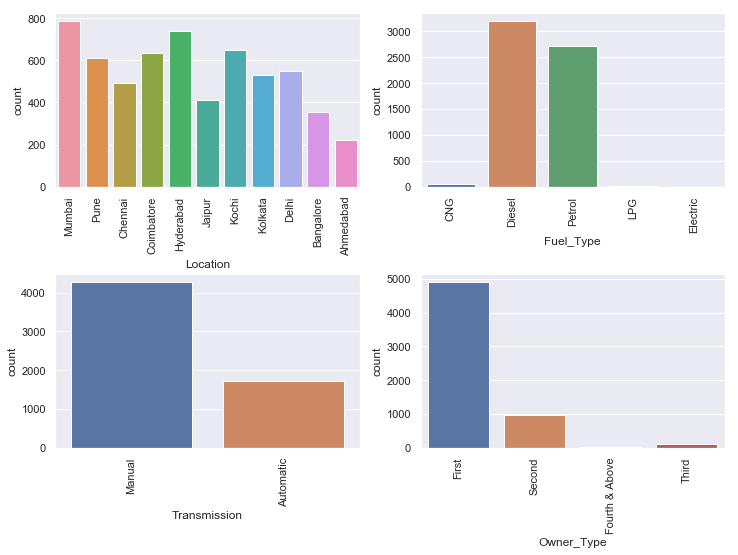

In [9]:
# Create a figure with 4 subplots
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

# Plot the number of times it entry appears
a = sns.countplot(cat_features[1], data=data, ax=ax[0][0])
a.set_xticklabels(a.get_xticklabels(), rotation='vertical')
b = sns.countplot(cat_features[2], data=data, ax=ax[0][1])
b.set_xticklabels(b.get_xticklabels(), rotation='vertical')
c = sns.countplot(cat_features[3], data=data, ax=ax[1][0])
c.set_xticklabels(c.get_xticklabels(), rotation='vertical')
d = sns.countplot(cat_features[4], data=data, ax=ax[1][1])
d.set_xticklabels(d.get_xticklabels(), rotation='vertical')



plt.show()


''

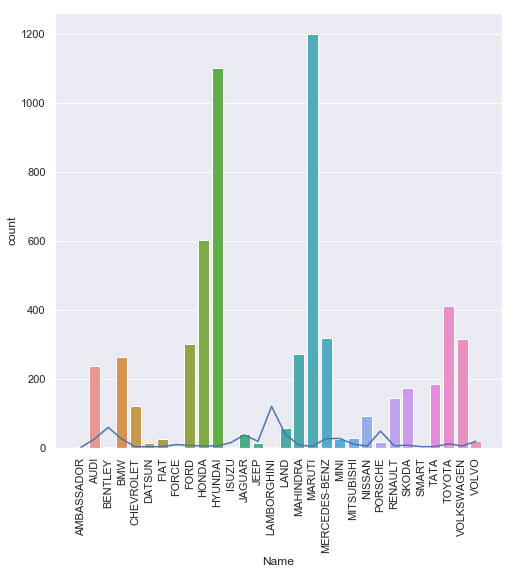

In [10]:
# Create a figure
plt.figure(figsize=(8, 8))
# Count the number of times a car was bought and plot the graph
count = sns.countplot(cat_features[0], data=data, order=data.groupby('Name').mean()['Price'].index)
count.set_xticklabels(count.get_xticklabels(), rotation='vertical')

# Plot the mean price of each car
price = sns.lineplot(data.groupby('Name').mean()['Price'].index, data.groupby('Name').mean()['Price'].values)
;

''

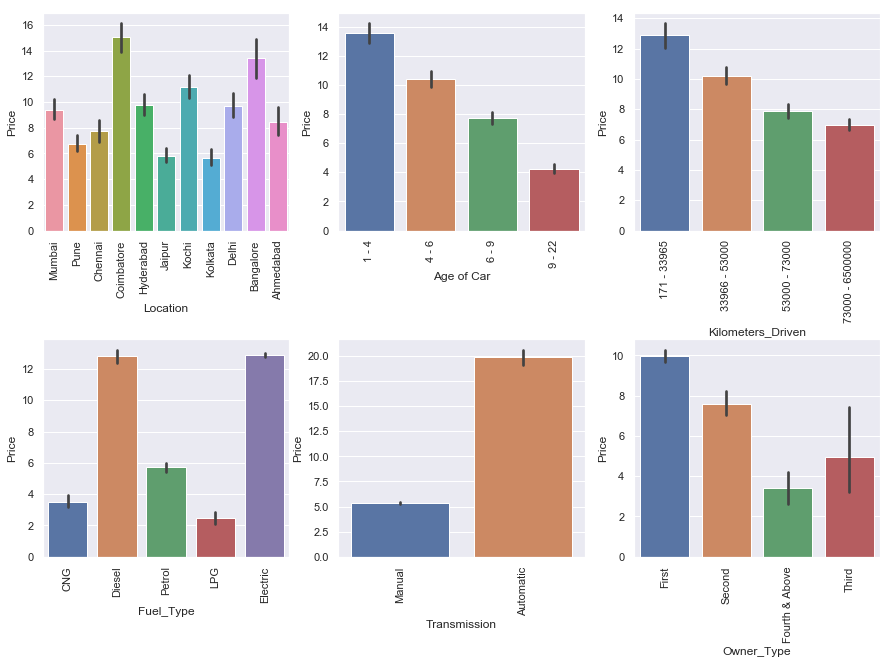

In [11]:
# Create a figure with 6 subplots
fig, ax = plt.subplots(2,3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Graph each categorical feature wrt to thee Price
a = sns.barplot(data.columns[1], 'Price', data=data, ax=ax[0][0])
a.set_xticklabels(a.get_xticklabels(), rotation='vertical')

b = sns.barplot(pd.qcut(data[data.columns[2]], 4), 'Price', data=data, ax=ax[0][1])
b.set_xticklabels(['1 - 4', '4 - 6', '6 - 9', '9 - 22'], rotation='vertical')
b.set_xlabel('Age of Car')

c = sns.barplot(pd.qcut(data[data.columns[3]], 4), 'Price', data=data, ax=ax[0][2])
c.set_xticklabels(['171 - 33965', '33966 - 53000', '53000 - 73000', '73000 - 6500000'], rotation='vertical')

d = sns.barplot(data.columns[4], 'Price', data=data, ax=ax[1][0])
d.set_xticklabels(d.get_xticklabels(), rotation='vertical')

e = sns.barplot(data.columns[5], 'Price', data=data, ax=ax[1][1])
e.set_xticklabels(e.get_xticklabels(), rotation='vertical')

f = sns.barplot(data.columns[6], 'Price', data=data, ax=ax[1][2])
f.set_xticklabels(f.get_xticklabels(), rotation='vertical')

;

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


''

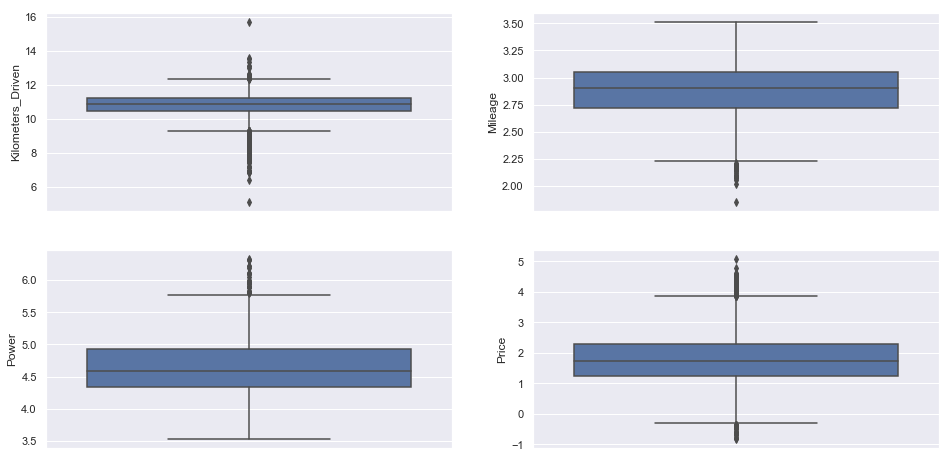

In [12]:
data1 = data.copy()

# Create a figure with 4 subplots    
fig, ax = plt.subplots(2,2, figsize=(16,8))

# Create a boxplot for the continuous features
box1 = sns.boxplot(y=np.log(data1[continuous_features[0]]), ax=ax[0][0])
box2 = sns.boxplot(y=np.log(data1[continuous_features[1]]), ax=ax[0][1])
box3 = sns.boxplot(y=np.log(data1[continuous_features[2]]), ax=ax[1][0])
box4 = sns.boxplot(y=np.log(data1[continuous_features[3]]), ax=ax[1][1])
;


In [13]:
# Carry out One Hot Encoder on the categorical featues
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

In [14]:
# Define the features or independent variable
X = data.drop(['Price'], axis=1)
# Define the label or dependent variable
y = data['Price']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Robust Scaler to the train data
scaler = RobustScaler()
scaler.fit(X_train[continuous_features[0:-1]])

# Transform Robust Scaler to the train and test data
X_train[continuous_features[0:-1]] = scaler.transform(X_train[continuous_features[0:-1]])
X_test[continuous_features[0:-1]] = scaler.transform(X_test[continuous_features[0:-1]])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

In [15]:
# Create a list of ML algorithms
models = []

models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))

# Evalaute each model
for name, model in models:
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    score = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print(f"{name} has an r2 score: {np.round(score.mean(), 3)}%, and SD : {np.round(score.std(), 4)}")


Linear Regression has an r2 score: 0.766%, and SD : 0.0657
Ridge Regression has an r2 score: 0.77%, and SD : 0.0735
Lasso Regression has an r2 score: 0.642%, and SD : 0.0922
Decision Tree has an r2 score: 0.813%, and SD : 0.0861
Random Forest has an r2 score: 0.902%, and SD : 0.0363


In [16]:
# Check for model performance on the test data
rf = RandomForestRegressor() 
%time rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2_score(y_test, y_pred)

Wall time: 6.33 s


0.8839473474168895

In [17]:
print(f'Mean absoluute error: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'Mean sqaured error: {metrics.mean_squared_error(y_test, y_pred)}')

Mean absoluute error: 1.4826187868480727
Mean sqaured error: 13.612802952279774


In [18]:
# Number of trees in random forest
n_estimators = [200, 350, 400]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Define some paramters
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap
         }

In [21]:
# Apply GridSearchCV with the defined paramters
model_search = GridSearchCV(rf, param_grid=params, scoring='r2')
%time model_search.fit(X_train, y_train)
y_pred_op = model_search.predict(X_test)

# Check metrics
print(f'r2 score: {r2_score(y_test, y_pred_op)}')
print(f'Mean absoluute error: {metrics.mean_absolute_error(y_test, y_pred_op)}')
print(f'Mean sqaured error: {metrics.mean_squared_error(y_test, y_pred_op)}')

Wall time: 26min
r2 score: 0.8861192498754874
Mean absoluute error: 1.4606301086194835
Mean sqaured error: 13.358042035209893


In [22]:
# Save the model
pickle.dump(model_search, open('model_final.plk', 'wb'))